**Some of the code refered from: https://www.kaggle.com/svpons/feature-engineering**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
#import pickle
import datetime
from datetime import date
#import os
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# 0. 整体思路
就是把session里面的数据按照id进行合并统计，得到一个表；再将它和train按照id进行合并从而到一个包含众多feature的表，进而提高拟合度

# 1. Session Data

In [2]:
df_sessions = pd.read_csv('sessions.csv')
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'], axis = 1)

In [3]:
df_sessions.head(3)

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42


In [4]:
df_sessions.shape

(10567737, 6)

In [5]:
df_sessions.isnull().sum()

action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
id                 34496
dtype: int64

## 1.1 Preparing Session data

因为有一些残缺值不一定就是NAN的格式，也有可能是None或者Nan，格式化使之一致

In [6]:
df_sessions.action = df_sessions.action.fillna('NAN')
df_sessions.action_type = df_sessions.action_type.fillna('NAN')
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN')
df_sessions.device_type = df_sessions.device_type.fillna('NAN')

In [7]:
print(df_sessions.action.value_counts().head(2), '\n\n', df_sessions.action.value_counts().tail(5))

show     2768278
index     843699
Name: action, dtype: int64 

 host_cancel    1
sldf           1
desks          1
reactivate     1
deauthorize    1
Name: action, dtype: int64


上面对数量的统计可以看出来有很多种方式的值过小，作为一个单独标签会增加模型的复杂度，考虑将出现频数小于100的全部归为OTHER

In [8]:
act_freq = 100
#这里使用np.unique和zip生成元组做为次数统计的字典
act = dict(zip(*np.unique(df_sessions.action, return_counts = True)))

df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)

#### zip的用法

In [9]:
a = [1, 2, 3]
b = [4, 5, 6]
c = [11, 12]

zip是将内部元素一一对应组成元组

In [10]:
list(zip(a, b))

[(1, 4), (2, 5), (3, 6)]

In [11]:
list(zip(a, b, c))
abc = list(zip(a, b, c))

添加\*就是zip的逆过程

In [12]:
list(zip(*abc))

[(1, 2), (4, 5), (11, 12)]

#### argsort 的用法
返回的是数字的序号

In [13]:
x = np.array([1, 6, 3, -1, 2, 4])
x.argsort()

array([3, 0, 4, 2, 5, 1], dtype=int64)

In [14]:
#这里加不加argsort都是一样的。数量并不会改变

f_act = df_sessions.action.value_counts().argsort()
f_act_detail = df_sessions.action_detail.value_counts().argsort()
f_act_type = df_sessions.action_type.value_counts().argsort()
f_dev_type = df_sessions.device_type.value_counts().argsort()

In [15]:
print(f_act.shape)
print(f_act_detail.shape)
print(f_act_type.shape)
print(f_dev_type.shape)

(231,)
(156,)
(11,)
(14,)


In [16]:
#grouping session by id. We will compute features from all rows with the same id.
dgr_sess = df_sessions.groupby(['id'])
len(dgr_sess)

135483

In [17]:
f_act.head()

show              230
index             229
search_results    227
personalize       228
search            226
Name: action, dtype: int64

这里要注意对列表的运算

* 如果是list1 + list2 则结果是一个list
* 如果是list1.append(list2) 则结果是两层list

示例如下：

In [18]:
x = []
y = [2]
z = [3]
a = x + y + z
x.append(y)
x.append(z)
print(a, x)

[2, 3] [[2], [3]]


## 1.2 FeatureEngineering

In [19]:
#Loop on dgr_sess to create all the features.
samples = []
cont = 0
ln = len(dgr_sess)

for g in dgr_sess:
    if cont % 10000 == 0:
        print("%s from %s" % (cont, ln))
    gr = g[1]   
    l = []
    #该g对应的id
    l.append(g[0])
    #该id下对应的数据集的长度
    l.append(len(gr))
    #浏览时间的缺失值用0补充
    sev = gr.secs_elapsed.fillna(0).values   
    
    '''
    action features
    计算每一个action的值出现的次数，均值和标准差
    '''    
    #总共有231种不同的action的值
    c_act = [0] * len(f_act)
    #i代表values的序号（0起），v代表values的值
    for i,v in enumerate(gr.action.values):
        '''
        f_act是一个Series，其中values是序列的index，每一个values出现的次数的排名是它的值
        c_act储存的是频数，刚开始全部act的计数都是0。如果action出现一次，则该处的频数+1
        '''
        c_act[f_act[v]] += 1
        
    #_是占位符，所以这里只需要求得action的计数而不需要values的值
    _, c_act_uqc = np.unique(gr.action.values, return_counts = True)
    ###这里c_act和c_act_uqc的区别是，前者是总共的action，可能有一些值是0，而后者是该id的，全部都不是0
    
    #将该id的action数目，均值和标准差添加到总量统计的后面
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l += c_act
    
    '''
    action_detail features
    计算每一个操作细节的出现次数，均值和标准差，同上
    '''
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1 
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts = True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    '''
    action_type features
    计算每一个操作类型的出现次数，均值和标准差，同上
    以及计算每一个操作类型的时间总和sum of sev
    '''
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        #时间求和
        l_act_type[f_act_type[v]] += sev[i]   
        #出现次数求和
        c_act_type[f_act_type[v]] += 1  
    #因为缺失值是用0填充的，所以在进行对数运算时添加了1以免报错，并且将结果转成list   
    l_act_type = np.log(1 + np.array(l_act_type)).tolist()
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts = True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    #比前两个多了一个时间量
    l = l + c_act_type + l_act_type   
    
    '''
    device_type features
    计算每一个设备类型的出现次数，均值和标准差
    '''
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type.values):
        c_dev_type[f_dev_type[v]] += 1 
    #这里添加了一个该id下所有设备类型的总数？这句话是不是重复了？
    #c_dev_type.append(len(np.unique(gr.device_type.values)))
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts = True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type   
    
    '''
    secs_elapsed features
    计算每一个id停留时间的统计特征和区间分布
    '''      
    l_secs = [0] * 5 
    l_log = [0] * 15
    #不明白这里为什么要有一个判断语句
    if len(sev) > 0:
        #时间的统计特征
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1])
        
        #将时间长度（取对数之后）分为15组，计算每一组的个数
        log_sev = np.log(1 + sev).astype(int)
        #这里的意思是将log_sev进行分组统计出现次数（已经转换为整数），统计的组数为15，返回值为每一组内的数量统计值
        #（即exp^15=300多万秒,根据describe，最大时间为1.799977e+06，所以分15组足够满足统计要求）
        l_log = np.bincount(log_sev, minlength = 15).tolist()                      
    l = l + l_secs + l_log
    #至此l的长度应该是1+1+231+156+（11*2）+14+3*4+（5+15）=457（后面转dataframe时去掉了id列所以编号是0-455）
    #按照顺序分别是id，len，action，action_detail，action_type*2（时间），device_type，（len,mean,std）*4，l_secs,l_log
    
    #samples的每一条记录是一个list，代表一个id对应的数据的处理结果
    samples.append(l)
    cont += 1

0 from 135483
10000 from 135483
20000 from 135483
30000 from 135483
40000 from 135483
50000 from 135483
60000 from 135483
70000 from 135483
80000 from 135483
90000 from 135483
100000 from 135483
110000 from 135483
120000 from 135483
130000 from 135483


In [20]:
len(samples)

135483

将samples从list转为更好操作和观察的dataframe

其中samples转为array后，第一个元素是id，其它元素是数据

In [21]:
samples = np.array(samples)
samp_ar = samples[:, 1:].astype(np.float16)
samp_id = samples[:, 0]

In [22]:
col_names = []  
for i in range(len(samples[0])-1):
    col_names.append('c_' + str(i)) 

In [23]:
#构建dataframe   
df_agg_sess = pd.DataFrame(samp_ar, columns = col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id

In [24]:
df_agg_sess.shape

(135483, 457)

In [25]:
df_agg_sess.head(10)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_447,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,id
id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,2.0,3.0,3.0,1.0,0.0,1.0,0.0,00023iyk9l
0010k6l0om,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,2.0,8.0,4.0,3.0,0.0,0.0,0.0,0010k6l0om
001wyh0pz8,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,30.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,001wyh0pz8
0028jgx1x1,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0028jgx1x1
002qnbzfs5,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,102.0,104.0,57.0,28.0,9.0,4.0,1.0,1.0,002qnbzfs5
0031awlkjq,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0031awlkjq
0035hobuyj,489.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159.0,66.0,47.0,35.0,38.0,12.0,5.0,0.0,1.0,0035hobuyj
00378ocvlh,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,8.0,10.0,12.0,5.0,3.0,0.0,2.0,0.0,00378ocvlh
00389675gq,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,19.0,18.0,18.0,16.0,9.0,2.0,0.0,0.0,00389675gq


**we have finished cleaning of sessions**

# 2. Training and testing data

In [26]:
train = pd.read_csv("train_users.csv")
test = pd.read_csv("test_users.csv")

In [27]:
train.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [28]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [29]:
print ('training dataset ({} rows) null value:\n'.format(train.shape[0]))
print (train.isnull().sum(axis = 0))
print ('\n' + '***' * 10 + '\n')
print ('test dataset ({} rows) null value:\n'.format(test.shape[0]))
print (test.isnull().sum(axis = 0))

training dataset (213451 rows) null value:

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

******************************

test dataset (62096 rows) null value:

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel             

In [30]:
train_row = train.shape[0]

# The label we need to predict
labels = train['country_destination'].values

# the id number is not useful for prediction. We need it for submission
id_test = test['id']

# drop the id column
# drop the date_first_booking since there is all Nan in test dataset which we figured out in the data exploration
# drop the label in training set
train.drop(['country_destination', 'date_first_booking', 'id'], axis = 1, inplace = True)
test.drop(['date_first_booking'], axis = 1, inplace = True)

In [31]:
labels

array(['NDF', 'NDF', 'US', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

## 2.1 Join the two dataset first
We may have a few things to deal with:
* 1. date_account_created: create some new features
* 2. timestamp_first_active: convert it to datetime data type
* 3. age column
* 4. one hot encoding the other features

In [32]:
df = pd.concat([train, test], axis = 0, ignore_index = True)
df.shape

E:\Py\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


(275547, 14)

## 2.2 Normal Cleaning

### 2.2.1 timestamp_first_active
第一次激活帐号的时间戳格式化

In [33]:
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[: 4]),
                                                                          int(x[4: 6]), 
                                                                          int(x[6: 8]),
                                                                          int(x[8: 10]),
                                                                          int(x[10: 12]),
                                                                          int(x[12:])))

In [34]:
tfa.head(10)

0   2009-03-19 04:32:55
1   2009-05-23 17:48:09
2   2009-06-09 23:12:47
3   2009-10-31 06:01:29
4   2009-12-08 06:11:05
5   2010-01-01 21:56:19
6   2010-01-02 01:25:58
7   2010-01-03 19:19:05
8   2010-01-04 00:42:11
9   2010-01-04 02:37:58
Name: timestamp_first_active, dtype: datetime64[ns]

**try to create some features:**
* numerical: year, month, day;
* time difference between dac and tfa;
* categorical: which season; weekday or weekend?
* ...


In [35]:
# create tfa_year, tfa_month, tfa_day feature
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])

In [36]:
#生成周几的类别变量
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa])

In [37]:
#将分类变量转换为虚拟/指示变量（即one hot encoding）
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd')
df = pd.concat((df, df_tfa_wd), axis = 1)
df.drop(['tfa_wd'], axis = 1, inplace = True)

In [38]:
df.iloc[:, :-12].head()

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow
0,direct,direct,NaN,2010-06-28,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,Web,0
1,seo,google,38.0,2011-05-25,untracked,Chrome,Mac Desktop,MALE,NaN,en,Web,0
2,direct,direct,56.0,2010-09-28,untracked,IE,Windows Desktop,FEMALE,NaN,en,Web,3
3,direct,direct,42.0,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,NaN,en,Web,0
4,direct,direct,41.0,2010-09-14,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,Web,0


In [39]:
df.iloc[:, -12:].head()

,signup_method,timestamp_first_active,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7
0,facebook,20090319043255,2009,3,19,0,0,0,1,0,0,0
1,facebook,20090523174809,2009,5,23,0,0,0,0,0,1,0
2,basic,20090609231247,2009,6,9,0,1,0,0,0,0,0
3,facebook,20091031060129,2009,10,31,0,0,0,0,0,1,0
4,basic,20091208061105,2009,12,8,0,1,0,0,0,0,0


In [40]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'

In [41]:
def get_season1(dt):
    dt = dt.date()
    dt = dt.replace(year = Y)
    return next(season for season, (start, end) in seasons
                if start <= dt <= end)

这里用到了next大佬说是迭代器常用，所以自己改成了get_season2()

>行为上有点区别，假如没有该元素，用next会报错，用for的会返回个None，如果外部有try-catch机制，那就不以言过了

In [42]:
def get_season2(dt):
    dt = dt.date()
    dt = dt.replace(year = Y)
    for season, (start, end) in seasons:
        if start <= dt <= end:
            return season

In [43]:
df['tfa_season'] = np.array([get_season2(x) for x in tfa])
df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season')
df = pd.concat((df, df_tfa_season), axis = 1)
df.drop(['tfa_season'], axis = 1, inplace = True)

In [44]:
df.head()

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,...,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,tfa_season_0,tfa_season_1,tfa_season_2,tfa_season_3
0,direct,direct,NaN,2010-06-28,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,...,0,0,1,0,0,0,1,0,0,0
1,seo,google,38.0,2011-05-25,untracked,Chrome,Mac Desktop,MALE,NaN,en,...,0,0,0,0,1,0,0,1,0,0
2,direct,direct,56.0,2010-09-28,untracked,IE,Windows Desktop,FEMALE,NaN,en,...,1,0,0,0,0,0,0,1,0,0
3,direct,direct,42.0,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,NaN,en,...,0,0,0,0,1,0,0,0,0,1
4,direct,direct,41.0,2010-09-14,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,...,1,0,0,0,0,0,0,0,0,1


### 2.2.2 date_account_created
账户创建时间

同上一个变量，这里又进行了相同的操作

In [46]:
dac = pd.to_datetime(df.date_account_created)

# create year, month, day feature for dac
df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])

# create features of weekday for dac
df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, prefix = 'dac_wd')
df = pd.concat((df, df_dac_wd), axis = 1)
df.drop(['dac_wd'], axis = 1, inplace = True)

# create season features fro dac

df['dac_season'] = np.array([get_season2(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, prefix = 'dac_season')
df = pd.concat((df, df_dac_season), axis = 1)
df.drop(['dac_season'], axis = 1, inplace = True)
df.head()

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,...,dac_wd_2,dac_wd_3,dac_wd_4,dac_wd_5,dac_wd_6,dac_wd_7,dac_season_0,dac_season_1,dac_season_2,dac_season_3
0,direct,direct,NaN,2010-06-28,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,...,0,0,0,0,0,0,0,0,1,0
1,seo,google,38.0,2011-05-25,untracked,Chrome,Mac Desktop,MALE,NaN,en,...,0,1,0,0,0,0,0,1,0,0
2,direct,direct,56.0,2010-09-28,untracked,IE,Windows Desktop,FEMALE,NaN,en,...,1,0,0,0,0,0,0,0,0,1
3,direct,direct,42.0,2011-12-05,untracked,Firefox,Mac Desktop,FEMALE,NaN,en,...,0,0,0,0,0,0,0,0,0,1
4,direct,direct,41.0,2010-09-14,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,...,1,0,0,0,0,0,0,0,1,0


### 2.2.3 Time span between dac and tfa may also be used as a feature

In [47]:
#a.subtract(b)是进行减法运算a-b
dt_span = dac.subtract(tfa).dt.days

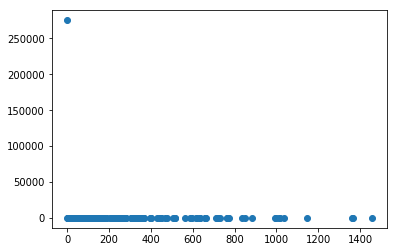

In [48]:
# there are many -1 days exsiting which means dac very close to tfa.
plt.scatter(dt_span.value_counts().index.values, dt_span.value_counts().values)

In [49]:
#将时间差作为一个类别变量加到模型里去
def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif (dt < 30) & (dt > -1):
        return 'OneMonth'
    elif (dt >= 30) & (dt <= 365):
        return 'OneYear'
    else:
        return 'other'

In [50]:
df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, prefix = 'dt_span')
df = pd.concat((df, df_dt_span), axis = 1)
df.drop(['dt_span'], axis = 1, inplace = True)

In [51]:
# drop the time feature after feature engineering
df.drop(['date_account_created','timestamp_first_active'], axis = 1, inplace = True)
df.head()

,affiliate_channel,affiliate_provider,age,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,...,dac_wd_6,dac_wd_7,dac_season_0,dac_season_1,dac_season_2,dac_season_3,dt_span_OneDay,dt_span_OneMonth,dt_span_OneYear,dt_span_other
0,direct,direct,NaN,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,Web,...,0,0,0,0,1,0,0,0,0,1
1,seo,google,38.0,untracked,Chrome,Mac Desktop,MALE,NaN,en,Web,...,0,0,0,1,0,0,0,0,0,1
2,direct,direct,56.0,untracked,IE,Windows Desktop,FEMALE,NaN,en,Web,...,0,0,0,0,0,1,0,0,0,1
3,direct,direct,42.0,untracked,Firefox,Mac Desktop,FEMALE,NaN,en,Web,...,0,0,0,0,0,1,0,0,0,1
4,direct,direct,41.0,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,Web,...,0,0,0,0,1,0,0,0,1,0


### 2.2.4 Age
进行分类，将14-90周岁设置为合理，其他的根据错误类型进行标注

In [52]:
av = df.age.values
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) #This are birthdays instead of age (estimating age by doing 2014 - value)
#av = np.where(np.logical_and(av<14, av>0), 4, av) #Using specific value=4 for age values below 14
#av = np.where(np.logical_and(av<2016, av>2010), 9, av) #This is the current year insted of age (using specific value = 9)
#av = np.where(av > 99, 110, av)  #Using specific value=110 for age values above 99
df['age'] = av

E:\Py\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
E:\Py\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [53]:
# Age has many abnormal values that we need to deal with. 
age = df.age

In [54]:
age.fillna(-1, inplace = True)

In [55]:
div = 15

def get_age(age):
    # age is a float number
    if age < 0:
        return 'NA'
    elif (age < div):
        return div
    elif (age <= div * 2):
        return div*2
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical'
        

In [56]:
# create age categorical features:
df['age'] = np.array([get_age(x) for x in age])
df_age = pd.get_dummies(df.age, prefix = 'age')
df_age.head()

,age_15,age_30,age_45,age_60,age_75,age_90,age_NA,age_Unphysical
0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [57]:
df = pd.concat((df, df_age), axis = 1)
df.drop(['age'], axis = 1, inplace = True)
df.head()

,affiliate_channel,affiliate_provider,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,...,dt_span_OneYear,dt_span_other,age_15,age_30,age_45,age_60,age_75,age_90,age_NA,age_Unphysical
0,direct,direct,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,Web,0,...,0,1,0,0,0,0,0,0,1,0
1,seo,google,untracked,Chrome,Mac Desktop,MALE,NaN,en,Web,0,...,0,1,0,0,1,0,0,0,0,0
2,direct,direct,untracked,IE,Windows Desktop,FEMALE,NaN,en,Web,3,...,0,1,0,0,0,1,0,0,0,0
3,direct,direct,untracked,Firefox,Mac Desktop,FEMALE,NaN,en,Web,0,...,0,1,0,0,1,0,0,0,0,0
4,direct,direct,untracked,Chrome,Mac Desktop,-unknown-,NaN,en,Web,0,...,1,0,0,0,1,0,0,0,0,0


In [58]:
df.shape

(275547, 58)

## 2.3 One Hot Encoding categorical features

In [59]:
# pay attention to the 'first_affiliate_tracked' when OHE since this one has missing values. 

feat_toOHE = ['gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']

In [60]:
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df[f], prefix = f, dummy_na = True)
    df.drop([f], axis = 1, inplace = True)
    df = pd.concat((df, df_ohe), axis = 1)

**Feature engineering completed at this stage**

In [61]:
df.shape

(275547, 211)

In [62]:
df.head()

,id,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,...,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_browser_nan
0,NaN,2009,3,19,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,2009,5,23,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,NaN,2009,6,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,2009,10,31,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,NaN,2009,12,8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Merge with sess

In [63]:
df_all = pd.merge(df, df_agg_sess, how = 'left')
df_all = df_all.drop(['id'], axis = 1)
df_all = df_all.fillna(-2)  #Missing features for samples without sesssion data.

#All types of null 
df_all['all_null'] = np.array([sum(r < 0) for r in df_all.values])

E:\Py\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [64]:
df_all.head(10)

,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_447,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,all_null
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
5,2010,1,1,0,0,0,0,1,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
6,2010,1,2,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
7,2010,1,3,0,0,0,0,0,0,1,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
8,2010,1,4,1,0,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456
9,2010,1,4,1,0,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,456


In [65]:
df_all.shape

(275547, 667)

# 4. split the train and test dataset now

In [66]:
# train_row is the numbers of row we recorded earlier. 

Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]

# 讲需要预测的目标变量的值进行重新编码
le = LabelEncoder()
le.fit(labels)
ytrain = le.transform(labels)

print (ytrain)

[ 7  7 10 ...  7  7  7]


In [67]:
Xtrain.to_csv("Airbnb_xtrain.csv")
Xtest.to_csv("Airbnb_xtest.csv")
labels.tofile("Airbnb_ytrain.csv", sep = '\n', format = '%s')